In [41]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torch

In [9]:
train_dataset = datasets.ImageFolder("/home/phd/Scrivania/Sara_Curti/images_split_onlynoprep/train")


In [64]:
from transformers import AutoImageProcessor, ViTMAEForPreTraining
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = train_dataset[2][0]

processor = AutoImageProcessor.from_pretrained('facebook/vit-mae-base')

processor.image_mean = [0.5700, 0.4539, 0.4795]
processor.image_std=[0.1733, 0.1792, 0.1882]

processor.do_normalize = False

model = ViTMAEForPreTraining.from_pretrained('facebook/vit-mae-base')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
loss = outputs.loss
mask = outputs.mask
ids_restore = outputs.ids_restore


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [65]:
reconstruction = model.unpatchify(outputs.logits)

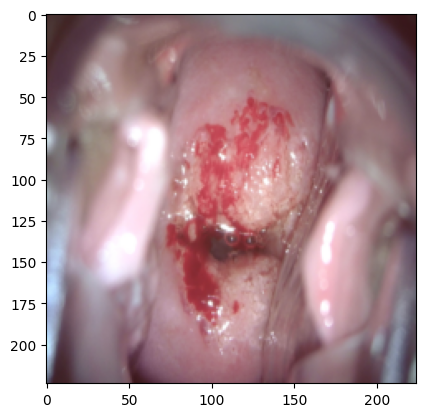

In [66]:
import matplotlib.pyplot as plt
plt.imshow(inputs['pixel_values'][0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.036022447..1.0391767].


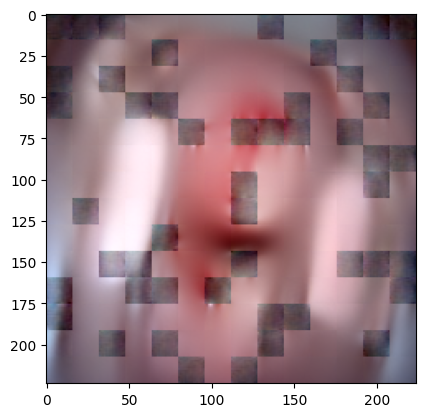

In [67]:
plt.imshow(reconstruction[0].permute(1, 2, 0).detach().numpy())

In [43]:
import torch
import requests
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from transformers import AutoImageProcessor, ViTMAEForPreTraining

# --------------------------------------------------
# 1. Load image and model
# --------------------------------------------------
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = image = train_dataset[0][0]

processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

# --------------------------------------------------
# 2. Preprocess and forward pass
# --------------------------------------------------
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

mask = outputs.mask                # [B, num_patches]
reconstruction = model.unpatchify(outputs.logits)  # [B, 3, H, W]
reconstruction = torch.clip(reconstruction, 0, 1)

# --------------------------------------------------
# 3. Prepare masked image for visualization
# --------------------------------------------------
patches = model.patchify(inputs["pixel_values"])   # [B, num_patches, patch_dim]
# expand mask to match patch dimensions
mask = mask.unsqueeze(-1).unsqueeze(-1)
mask = mask.expand(-1, -1, patches.shape[-1])
# apply mask (zero masked patches)
masked_patches = patches * (1 - mask)
# unpatchify
masked_img = model.unpatchify(masked_patches)
masked_img = torch.clip(masked_img, 0, 1)

# --------------------------------------------------
# 4. Convert to numpy for display
# --------------------------------------------------
def to_numpy(img_tensor):
    return img_tensor.detach().cpu().permute(1, 2, 0).numpy()

orig = to_numpy(inputs["pixel_values"][0])
masked = to_numpy(masked_img[0])
recon = to_numpy(reconstruction[0])

# --------------------------------------------------
# 5. Plot
# --------------------------------------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow((orig - orig.min()) / (orig.max() - orig.min()))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(masked)
plt.title("Masked Input")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(recon)
plt.title("Reconstructed Image")
plt.axis("off")

plt.show()


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


RuntimeError: expand(torch.FloatTensor{[1, 196, 1, 1]}, size=[-1, -1, 768]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)

In [15]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
# from pytorch_lightning.loggers import TensorBoardLogger
from transformers import AutoImageProcessor, ViTMAEForPreTraining

# ----------------------------
# 1. Config
# ----------------------------
MODEL_NAME = "facebook/vit-mae-base"
DATA_DIR = "/home/phd/Scrivania/Sara_Curti/data"  # expects subfolders: data/train and data/val
BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 200
NUM_WORKERS = 4

# ----------------------------
# 2. Load processor + datasets
# ----------------------------
image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
dataset = load_dataset("imagefolder", data_dir=DATA_DIR)

def collate_fn(examples):
    images = [e["image"].convert("RGB") for e in examples]
    inputs = image_processor(images, return_tensors="pt")
    return inputs

train_loader = DataLoader(
    dataset["train"], batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, collate_fn=collate_fn
)
val_loader = DataLoader(
    dataset["validation"], batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=collate_fn
)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [23]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
image_processor.do_normalize = False
# image_processor(dataset['train'][0]['image'])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


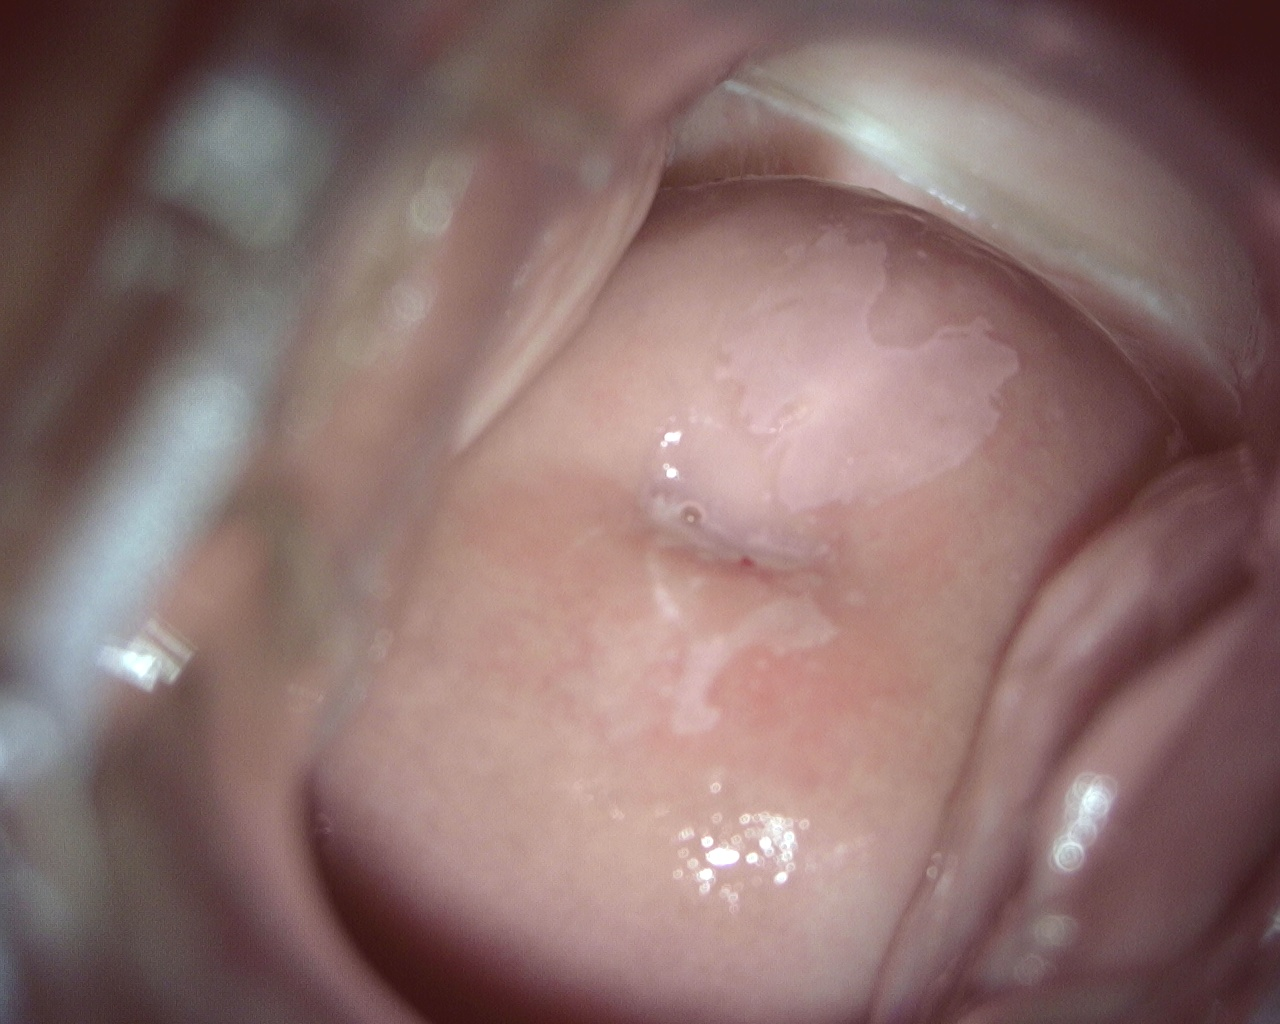

In [25]:
dataset['train'][0]['image']

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1727512..3.0474334].


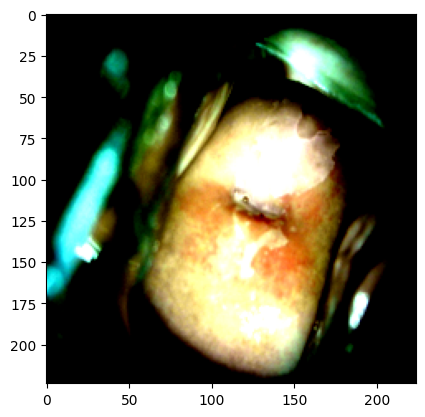

In [35]:
import matplotlib.pyplot as plt
image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
image_processor.do_normalize = True
image_processor.image_mean = [0.5700, 0.4539, 0.4795]
image_processor.image_std=[0.1733, 0.1792, 0.1882]
plt.imshow(torch.tensor(image_processor(dataset['train'][0]['image'])['pixel_values'][0]).permute(1, 2, 0))

In [50]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
image_processor.do_normalize = True
image_processor.image_mean = [0.5700, 0.4539, 0.4795]
image_processor.image_std=[0.1733, 0.1792, 0.1882]
torch.tensor(image_processor(dataset['train'][5]['image'])['pixel_values'][0]).mean()

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


tensor(-0.5061)